In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time
import copy

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready

from utils import plot_learning
from envs.single_photon_env import SinglePhotonLangevinReadoutEnv
from env_configs import get_sherbrooke_config, get_kyoto_config

from rl_algos.ppo_continuous import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Kyoto Params and RL Params

k_config = get_kyoto_config()
k_env_config = copy.deepcopy(k_config)

num_envs = 256
num_updates = 5000
kyoto_config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 128,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": k_env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

In [4]:
kyoto_env = SinglePhotonLangevinReadoutEnv(**k_config)

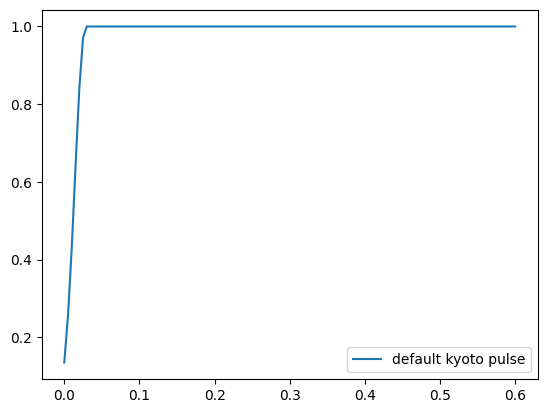

In [5]:
# Default Kyoto Action

ts = kyoto_env.ts_action

gauss_sigma = 0.0142
num_sigma = 2.
total_duration = k_config["tau_0"]

default_pulse = jnp.heaviside((total_duration - num_sigma * gauss_sigma) - ts, 1.) * jnp.heaviside(ts - num_sigma * gauss_sigma, 0.)
default_pulse += jnp.heaviside(num_sigma * gauss_sigma - ts, 1.) * jnp.exp(-(ts - num_sigma * gauss_sigma)**2 / (2 * gauss_sigma**2))
default_pulse += jnp.heaviside(ts - (total_duration - num_sigma * gauss_sigma), 1.) * jnp.exp(-(ts - (total_duration - num_sigma * gauss_sigma))**2 / (2 * gauss_sigma**2))

plt.plot(ts, default_pulse, label='default kyoto pulse')
plt.legend()
plt.show()

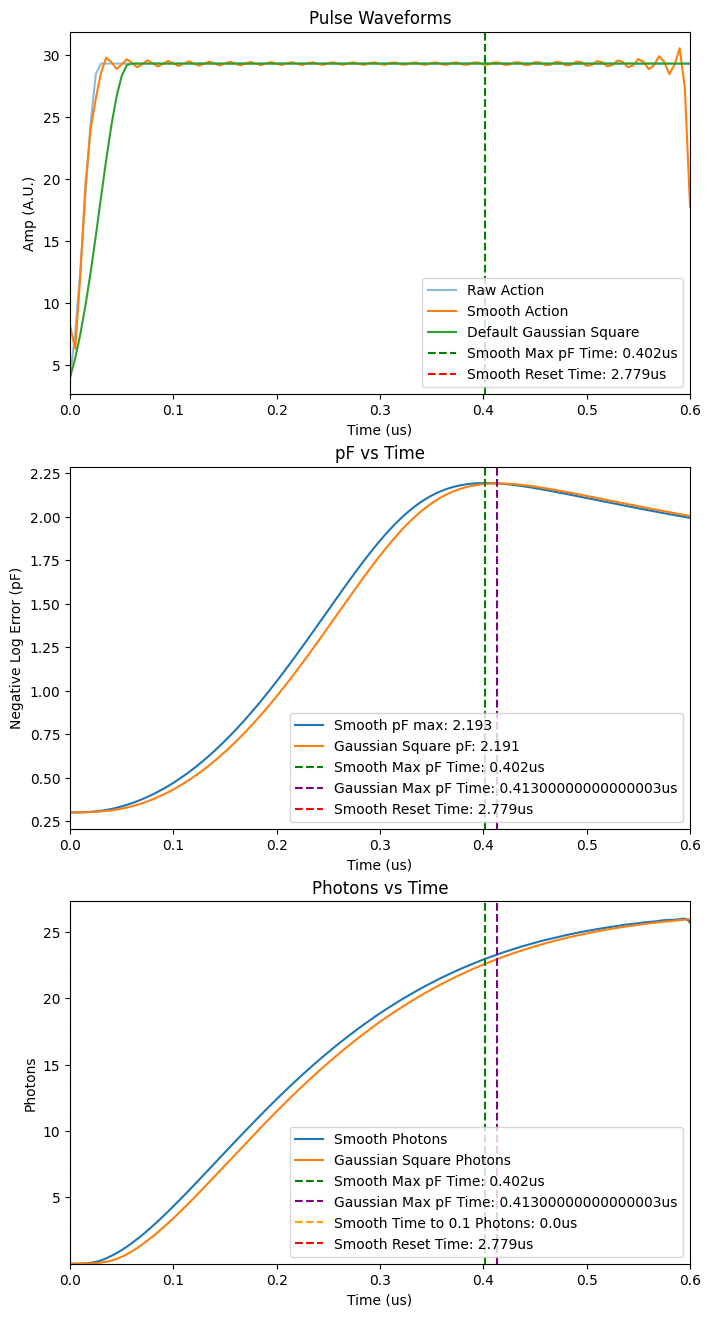

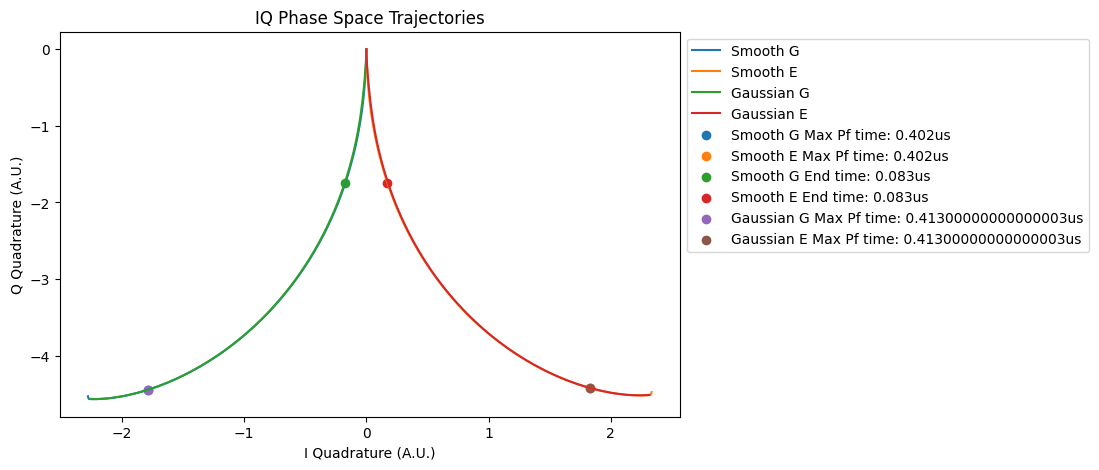

In [6]:
kyoto_env.rollout_action(_rng, default_pulse)

In [ ]:
k_env_config["time_coeff"] = 2.0
k_env_config["smoothness_coeff"] = 1.0

k_env_config

In [7]:
kyoto_config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 128,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": k_env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

In [8]:
kyoto_train = jit(PPO_make_train(kyoto_config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
kyoto_result = kyoto_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: -58.679
max pF: 2.0420000000000003
max photon: 22.43
photon time: 0.8530000000000001
real photon reset time: 0.5778
smoothness: 0.010615
bandwidth: 35.059
pulse reset val: 0.267
global update: 200
reward: -50.838
max pF: 2.118
max photon: 23.849
photon time: 0.791
real photon reset time: 0.5708
smoothness: 0.008085
bandwidth: 30.294
pulse reset val: 0.2
global update: 300
reward: -44.671
max pF: 2.136
max photon: 24.588
photon time: 0.6707000000000001
real photon reset time: 0.5539000000000001
smoothness: 0.006261
bandwidth: 26.989
pulse reset val: 0.17400000000000002
global update: 400
reward: -41.202
max pF: 2.15
max photon: 24.181
photon time: 0.6411
real photon reset time: 0.5428000000000001
smoothness: 0.005285
bandwidth: 24.412
pulse reset val: 0.14400000000000002
global update: 500
reward: -36.736000000000004
max pF: 2.17
max photon: 24.619
photon time: 0.598
real photon reset time: 0.5395
smoothness: 0.004683
bandwidth: 

In [9]:
# Extracting Results

k_metrics = kyoto_result["metrics"]

k_rewards = k_metrics["reward"]
k_max_pFs = k_metrics["max pF"]
k_max_photons = k_metrics["max photon"]
k_photon_times = k_metrics["photon time"]
k_smoothnesses = k_metrics["smoothness"]
k_bandwidths = k_metrics["bandwidth"]
k_actions = k_metrics["action"]
k_amps = k_metrics["pulse reset val"]

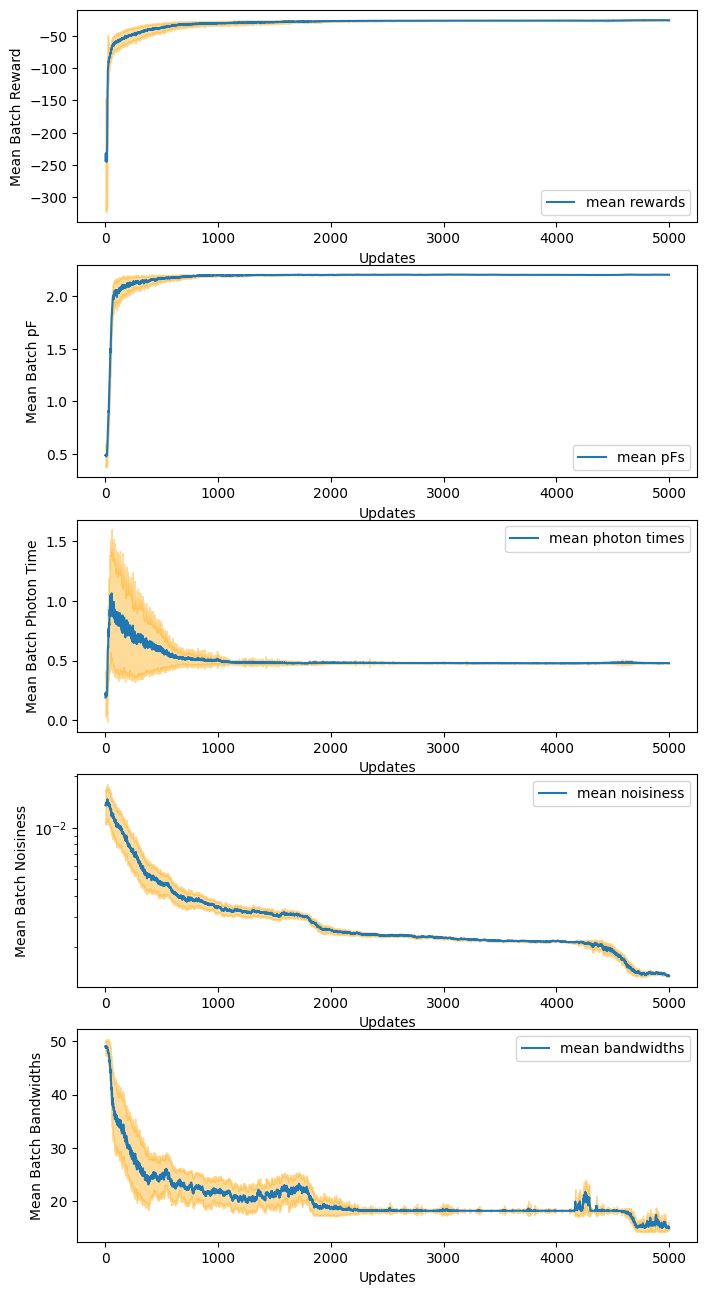

In [10]:
plot_learning(
    rewards=k_rewards,
    max_pFs=k_max_pFs,
    photon_times=k_photon_times,
    smoothnesses=k_smoothnesses,
    bandwidths=k_bandwidths,
)

In [11]:
kyoto_reward_env = SinglePhotonLangevinReadoutEnv(**k_env_config)

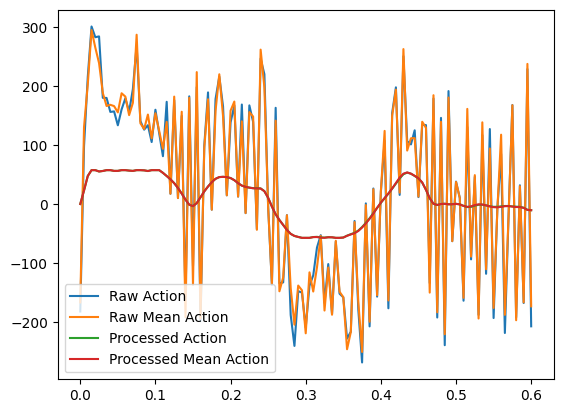

In [12]:
k_final_action = k_actions[-1, 0]
k_mean_action = jnp.mean(k_actions[-1], axis=0)
k_final_processed_action = kyoto_env.prepare_action(k_final_action)
k_final_processed_mean_action = kyoto_env.prepare_action(k_mean_action)

plt.plot(kyoto_env.ts_action, k_final_action * kyoto_env.a0, label='Raw Action')
plt.plot(kyoto_env.ts_action, k_mean_action * kyoto_env.a0, label='Raw Mean Action')
plt.plot(kyoto_env.ts_action, k_final_processed_action, label='Processed Action')
plt.plot(kyoto_env.ts_action, k_final_processed_mean_action, label='Processed Mean Action')
plt.legend()
plt.show()

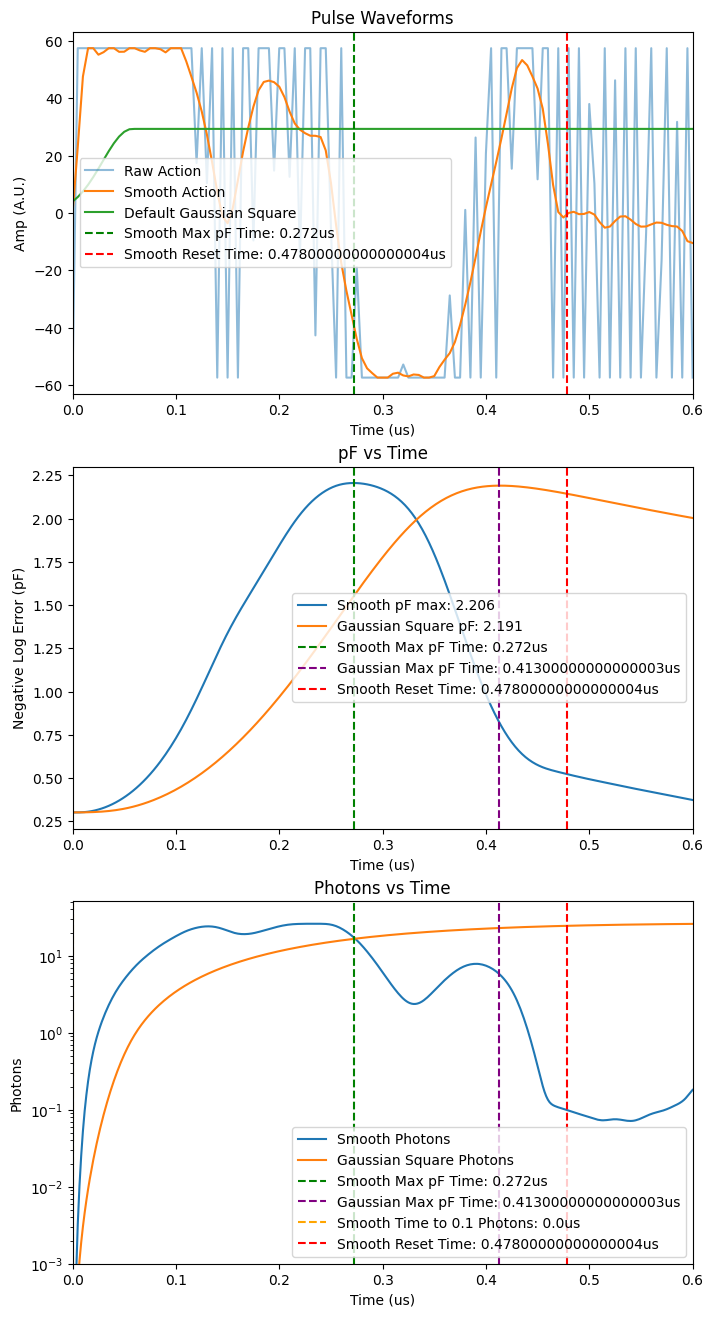

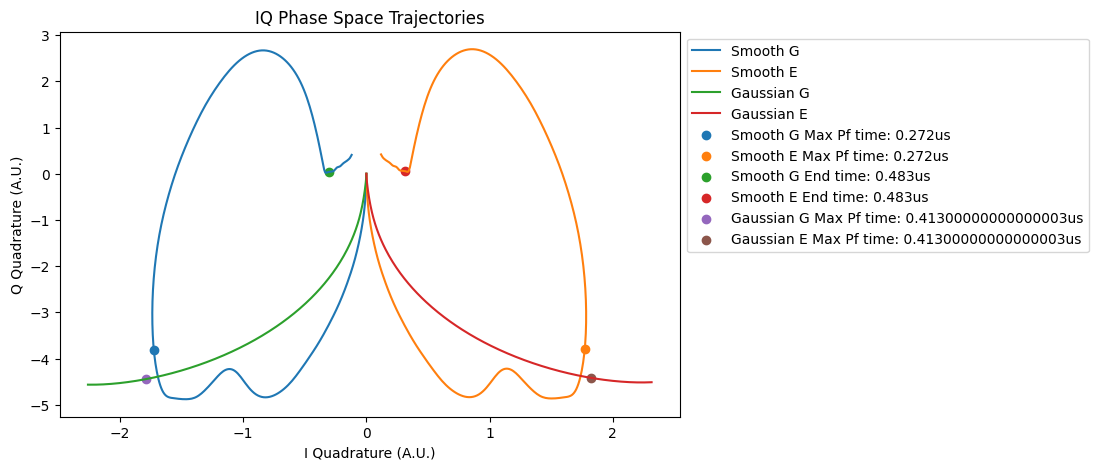

In [13]:
kyoto_reward_env.rollout_action(_rng, k_final_action, photon_log_scale=True)